In [46]:
# import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Import UUID to generate unique file names
import uuid

In [47]:
# Import Tensorflow Libraries - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [48]:
# Avoid OOM errosby setting GPU Memory Coonsumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


## Collecting Negative Dataset

In [49]:
# setup path


PDS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [50]:
# Make Directories


# os.makedirs(PDS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [51]:
# Move lfw images to the follwoing repository


# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

## Collecting positive and anchor dataset

In [52]:
# Establish a connection to webcam
# It is set to 4 so that this cell doesnt accidently run, set it to 0 to start capturing images from webcam
# q to quit, a to save anchor images, p to save positive images

cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()

    # Resizing the frame to 250x250
    frame = frame[120:120+250, 200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        cv2.imwrite(os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg'), frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        cv2.imwrite(os.path.join(PDS_PATH, f'{uuid.uuid1()}.jpg'), frame)

    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [53]:
# Getting image directory paths for anchor, negative and positive images

anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(PDS_PATH + '/*.jpg').take(300)

In [54]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\126622c1-0d9f-11f1-bf84-c8a3e8774b86.jpg'


## Preprocessing

In [55]:
def preprocess(file_path):
    """
    Preprocesses an image file for face recognition model input.
    
    This function reads a JPEG image from the given file path, decodes it,
    resizes it to 100x100 pixels, and normalizes pixel values to the range [0, 1].
    
    Args:
        file_path (str): Path to the JPEG image file.
    
    Returns:
        tf.Tensor: Preprocessed image tensor with shape (100, 100, 3) and values in [0, 1].
    """
    # Read the image file as raw bytes
    byte_img = tf.io.read_file(file_path)
    
    # Decode the JPEG bytes into a tensor
    img = tf.io.decode_jpeg(byte_img)
    
    # Resize the image to 100x100 pixels using bilinear interpolation
    img = tf.image.resize(img, (100, 100))
    
    # Normalize pixel values from [0, 255] to [0, 1]
    img = img / 255.0
    
    return img

In [56]:
preprocess('data\\anchor\\33a95d01-0d9f-11f1-8a94-c8a3e8774b86.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        ...,
        [0.9372549 , 0.9411765 , 0.91764706],
        [0.9372549 , 0.9411765 , 0.91764706],
        [0.9372549 , 0.9411765 , 0.91764706]],

       [[0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        ...,
        [0.93333334, 0.94411767, 0.91862744],
        [0.93333334, 0.94411767, 0.91862744],
        [0.93333334, 0.94411767, 0.91862744]],

       [[0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        ...,
        [0.93333334, 0.9411765 , 0.92156863],
        [0.93333334, 0.9411765 , 0.92156863],
        [0.93333334, 0.9411765 , 0.92156863]],

       ...,

       [[0.1254902 , 0.13333334, 0.0882353 ],
        [0.12

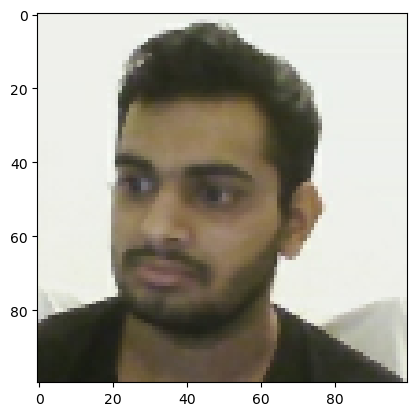

In [57]:
plt.imshow(preprocess('data\\anchor\\33a95d01-0d9f-11f1-8a94-c8a3e8774b86.jpg'))

In [58]:
preprocess('data\\anchor\\33a95d01-0d9f-11f1-8a94-c8a3e8774b86.jpg').numpy().max()

0.98357844

In [59]:
# dataset.map(preprocess)

## Create Labelled Dataset

In [60]:
# (anchor, positive) => 1, 1, 1, 1, 1
# (anchor, negative) => 0, 0, 0, 0, 0

In [61]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [62]:
samples = data.as_numpy_iterator()

In [63]:
example = samples.next()

In [64]:
example

(b'data\\anchor\\2bdae96c-0d9f-11f1-ac2e-c8a3e8774b86.jpg',
 b'data\\positive\\ab15ec23-0d9f-11f1-a4c4-c8a3e8774b86.jpg',
 1.0)

## Build Train and Test partition

In [65]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [66]:
res = preprocess_twin(*example)

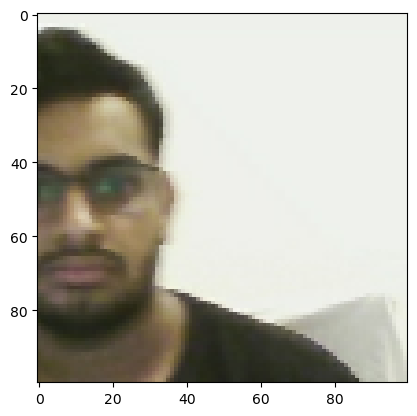

In [67]:
plt.imshow(res[0])

In [68]:
res[2]

1.0

In [69]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [70]:
# Create training partition (70%)
train_data = data.take(round(len(data) * 0.7))

# Apply batching and prefetching to training data
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [71]:
# Create testing partition (remaining 30%)
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))

# Apply batching and prefetching to testing data
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Engineering

In [72]:
# Embedding Layer
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    # First Block - Conv => ReLU => MaxPool
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    # Second Block - Conv => ReLU => MaxPool
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    # Third Block - Conv => ReLU => MaxPool
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    # Fourth Block - Conv => ReLU
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    # Flatten the output and feed it into a Dense layer with sigmoid activation
    f1 = Flatten()(c4)
    # The output of the Dense layer will be the embedding vector for the input image
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [73]:
# Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [74]:
# Build the Siamese LSTM Model
def siamese_model():
    # Anchor Image Input in the Siamese Network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    # Validation Image Input in the Siamese Network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Combine siamese distance components
    embedding = make_embedding()
    siamese_layer = L1Dist()
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [75]:
# Setup Loss function and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [76]:
# Establishing checkpoints to save the best model
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, Siamese=siamese_model())

In [77]:
# Build train step function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image from batch
        X = batch[:2]
        # Get label (1 for positive, 0 for negative) from batch
        y = batch[2]

        # Forward pass through the model
        yhat = checkpoint.Siamese(X, training=True)

        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    # Calculate gradients
    grad = tape.gradient(loss, checkpoint.Siamese.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, checkpoint.Siamese.trainable_variables))

    return loss

In [78]:
# Build Training Loop
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print(f'Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))

        # Train step
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx + 1)

    # Save checkpoint after every  10 epoch
    if epoch % 10 == 0:
        checkpoint.save(checkpoint_prefix)

In [35]:
# Train the model
EPOCHS = 50
train(train_data, EPOCHS)

Epoch 1/50
27/27 [==============================] - 25s 345ms/step
Epoch 2/50
27/27 [==============================] - 9s 340ms/step
Epoch 3/50
27/27 [==============================] - 9s 329ms/step
Epoch 4/50
27/27 [==============================] - 9s 332ms/step
Epoch 5/50
27/27 [==============================] - 10s 380ms/step
Epoch 6/50
27/27 [==============================] - 10s 395ms/step
Epoch 7/50
27/27 [==============================] - 10s 395ms/step
Epoch 8/50
27/27 [==============================] - 10s 397ms/step
Epoch 9/50
27/27 [==============================] - 11s 410ms/step
Epoch 10/50
27/27 [==============================] - 10s 395ms/step
Epoch 11/50
27/27 [==============================] - 11s 403ms/step
Epoch 12/50
27/27 [==============================] - 10s 396ms/step
Epoch 13/50
27/27 [==============================] - 10s 397ms/step
Epoch 14/50
27/27 [==============================] - 10s 399ms/step
Epoch 15/50
27/27 [==============================] - 10s 399

In [79]:
# Import Metrics
from tensorflow.keras.metrics import Precision, Recall

In [140]:
# Get a batch of test data
test_input, test_val, y_label = test_data.as_numpy_iterator().next()

In [141]:
# Make Predictions
y_hat = checkpoint.Siamese.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 26ms/step


array([[0.49950755],
       [0.5005327 ],
       [0.5004269 ],
       [0.5005467 ],
       [0.50039923],
       [0.4995031 ],
       [0.50012374],
       [0.49973026],
       [0.5002996 ],
       [0.50072485],
       [0.5017484 ],
       [0.5003583 ],
       [0.5005103 ],
       [0.5006631 ],
       [0.49977764],
       [0.49983364]], dtype=float32)

In [142]:
# Post-processing the predictions
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]

In [143]:
y_label

array([0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [144]:
# Calculate Recall and Precision
m = Recall()
m.update_state(y_label, y_hat)
print(f'Recall: {m.result().numpy()}')

p = Precision()
p.update_state(y_label, y_hat)
print(f'Precision: {p.result().numpy()}')

Recall: 0.699999988079071
Precision: 0.6363636255264282


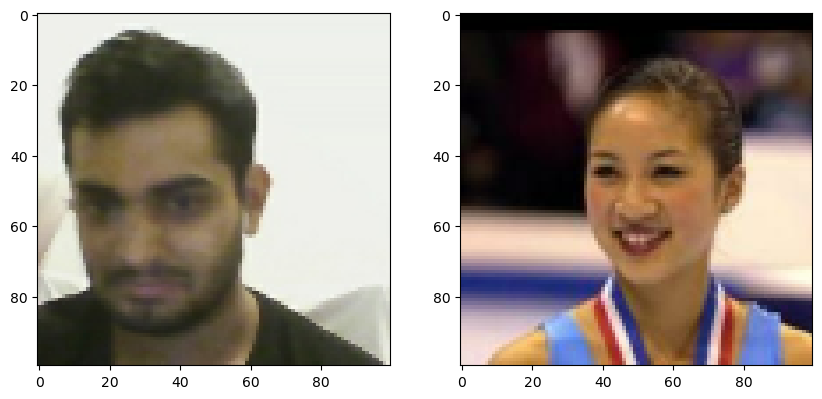

In [147]:
# Visialize a few of the test results
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])
plt.show()

In [149]:
# Save the model
checkpoint.Siamese.save('siamese_model.h5')

In [150]:
# Reload the model
model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [155]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][